In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import h5py
import pyvisa
import time
from scipy.signal import savgol_filter
import scipy.signal as signal
from scipy import interpolate
from scipy.signal import windows
from matplotlib.ticker import MaxNLocator
from scipy.optimize import least_squares

In [2]:
factor = 2
SMALL_SIZE = factor*8
MEDIUM_SIZE = factor*10
BIGGER_SIZE = factor*12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Plotting functions

In [19]:
def plot(rn_arr, fname="test.hdf", ylim=None, win_len=51, comment="",
         V0=None, Voffs=None, win_fn=windows.boxcar):
    # get data from file
    with h5py.File(fname, 'r') as f:
        C_LPF_uF = f[rn_arr[0]].attrs["C_LPF_uF"]
        dset = np.concatenate([np.array(f[rn]) for rn in rn_arr])
        DMM_temp = [f[rn].attrs["DMM_temp"] for rn in rn_arr]
        
    t = dset[:,0] - dset[0,0]
    if not V0:
        V0 = np.average(dset[:,1])
    if not Voffs:
        ratio_ppm = (dset[:,1] - V0) / V0 * 1e6
    else:
        ratio_ppm = (dset[:,1] - Voffs) / V0 * 1e6

    # choose time unit
    if t[-1] > 24*3600:
        t_unit = "days"
        div = 24*3600
    elif t[-1] > 3600:
        t_unit = "h"
        div = 3600
    elif t[-1] > 60:
        t_unit = "min"
        div = 60
    else:
        t_unit = "s"
        div = 1

    # plot the data
    fig, ax = plt.subplots()
    ax.plot(t/div, ratio_ppm, color="gray", label="data")
    ratio_ppm_win = np.convolve(ratio_ppm, win_fn(win_len)/np.sum(win_fn(win_len)), mode="same")
    ax.plot(t/div, ratio_ppm_win, color="black", label=f"{win_fn.__name__}({win_len})")
    
    # linear fit
    p1 = np.polyfit(t/div, ratio_ppm, 1)
    plt.plot(t/div, np.poly1d(p1)(t/div), color="red", label=f"${p1[0]:.2f}t+{p1[1]:.2f}$")
    
    # plot format
    ax.set_xlabel(f"time [{t_unit}]")
    ax.set_ylabel("$\\frac{V - V_0}{V_0}$ [ppm]")
    ax.set_title(f"{comment}$C_\\mathrm{{LPF}}$ = {C_LPF_uF} $\mu$F, $V_0={V0:.9f}\;$V")
    ax.set_ylim(ylim)
    ax.legend(loc="upper right")
    ax.grid()
    
    return DMM_temp

In [4]:
def plot_spectrum(rn_arr, fname="test.hdf", ylim=None, comment="",
                  V0=None, win_fn=windows.boxcar, win_len=1):
    # get data from file
    with h5py.File(fname, 'r') as f:
        C_LPF_uF = f[rn_arr[0]].attrs["C_LPF_uF"]
        dset = np.concatenate([np.array(f[rn]) for rn in rn_arr])
        
    t = dset[:,0] - dset[0,0]
    if not V0:
        V0 = np.average(dset[:,1])
    ratio_ppm = (dset[:,1] - V0) / V0 * 1e6
    
    # plot the spectrum
    f_arr = np.fft.rfftfreq(len(t), np.average(np.diff(t)))
    NSD = lambda x : np.sqrt(2 * np.abs(np.fft.rfft(x))**2 / (len(x) / np.average(np.diff(t)))) # [Heinzel, Gerhard, Albrecht Rüdiger, and Roland Schilling. "Spectrum and spectral density estimation by the Discrete Fourier transform (DFT), including a comprehensive list of window functions and some new at-top windows." (2002). https://holometer.fnal.gov/GH_FFT.pdf]
    fig, ax = plt.subplots()
    i0 = win_len//2
    ax.loglog(f_arr[i0:], NSD(ratio_ppm)[i0:], color="gray", label="data")
    NSD_win = np.convolve(NSD(ratio_ppm), win_fn(win_len)/np.sum(win_fn(win_len)), mode="same")
    ax.loglog(f_arr[i0:], NSD_win[i0:], color="black", label=f"{win_fn.__name__}({win_len})")
    
    # plot format
    ax.set_ylabel("NSD [ppm/$\sqrt{\mathrm{Hz}}$]")
    ax.set_title(f"{comment}$C_\\mathrm{{LPF}}$ = {C_LPF_uF} $\mu$F, $V_0={V0:.9f}\;$V")
    ax.set_ylim(ylim)
    ax.legend()
    ax.set_xlabel("frequency [Hz]")
    ax.grid()

In [5]:
def plot_spectra(rn_arr_arr, lab_arr, V0_arr, fname="test.hdf", ylim=None,
                 hline=None, vline=None, legend_pos=None,
                 win_fn=windows.boxcar, win_len=1):
    fig, ax = plt.subplots()
    
    for rn_arr, lab, V0 in zip(rn_arr_arr, lab_arr, V0_arr):
        # get data from file
        with h5py.File(fname, 'r') as f:
            C_LPF_uF = f[rn_arr[0]].attrs["C_LPF_uF"]
            dset = np.concatenate([np.array(f[rn]) for rn in rn_arr])

        t = dset[:,0] - dset[0,0]
        if not V0:
            V0 = np.average(dset[:,1])
        ratio_ppm = (dset[:,1] - V0) / V0 * 1e6

        # plot the spectrum
        f_arr = np.fft.rfftfreq(len(t), np.average(np.diff(t)))
        NSD = lambda x : np.sqrt(2 * np.abs(np.fft.rfft(x))**2 / (len(x) / np.average(np.diff(t)))) # [Heinzel, Gerhard, Albrecht Rüdiger, and Roland Schilling. "Spectrum and spectral density estimation by the Discrete Fourier transform (DFT), including a comprehensive list of window functions and some new at-top windows." (2002). https://holometer.fnal.gov/GH_FFT.pdf]
        if win_fn:
            NSD_win = np.convolve(NSD(ratio_ppm), win_fn(win_len)/np.sum(win_fn(win_len)), mode="same")
            i0 = win_len//2
            ax.loglog(f_arr[i0:], NSD_win[i0:], label=f"{lab} ({V0:.3f} V)")
        else:
            ax.loglog(f_arr, NSD(ratio_ppm), label=f"{lab} ({V0:.3f} V)")
    
    # line markers
    if hline:
        ax.axhline(y=hline, ls="--", color="gray")
    if vline:
        ax.axvline(x=vline, ls="--", color="gray")
    
    # plot format
    ax.set_ylabel("NSD [ppm/$\sqrt{\mathrm{Hz}}$]")
    ax.set_ylim(ylim)
    ax.legend(loc=legend_pos)
    ax.set_xlabel("frequency [Hz]")
    ax.grid()

### Testing

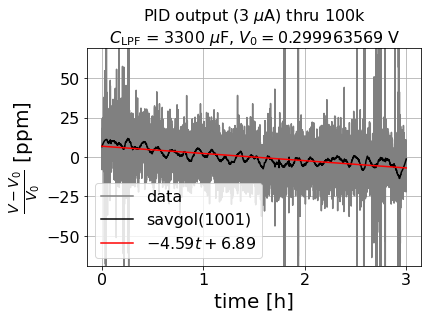

In [159]:
DMM_temp = plot(
    rn_arr  = [f"A-{i}" for i in range(3)],
    ylim    = (-69, 69),
    win_len = 1001,
    comment = "PID output ($3\;\mu$A) thru 100k\n",
)

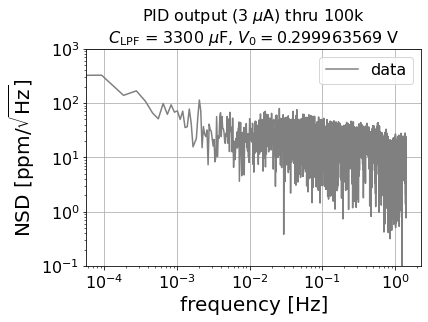

In [160]:
plot_spectrum(
    rn_arr  = [f"A-{i}" for i in range(3)],
    ylim    = (1e-1, 1e3),
    comment = "PID output ($3\;\mu$A) thru 100k\n",
)

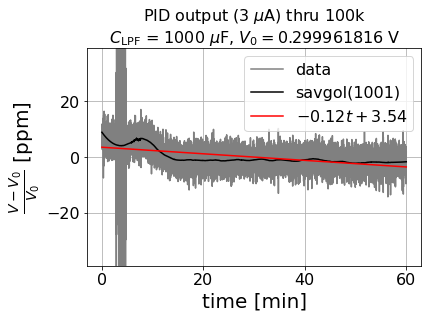

In [165]:
DMM_temp = plot(
    rn_arr  = [f"B-{i}" for i in range(1)],
    ylim    = (-39, 39),
    win_len = 1001,
    comment = "PID output ($3\;\mu$A) thru 100k\n",
)

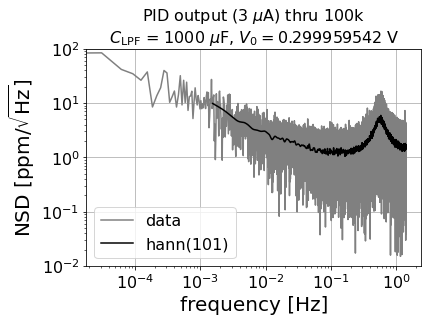

In [300]:
plot_spectrum(
    rn_arr  = [f"B-{i}" for i in range(5,14)],
    ylim    = (1e-2, 1e2),
    comment = "PID output ($3\;\mu$A) thru 100k\n",
    win_fn  = windows.hann,
    win_len = 101,
)

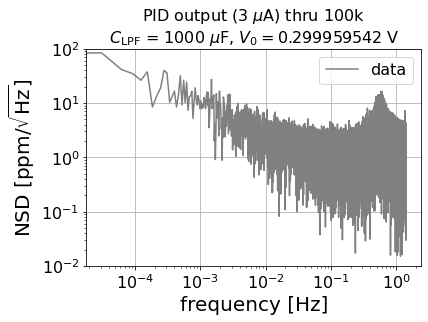

In [164]:
plot_spectrum(
    rn_arr  = [f"B-{i}" for i in range(5,14)],
    ylim    = (1e-2, 1e2),
    comment = "PID output ($3\;\mu$A) thru 100k\n",
)

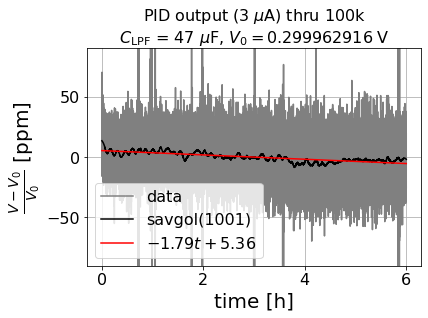

In [166]:
DMM_temp = plot(
    rn_arr  = [f"C-{i}" for i in range(6)],
    ylim    = (-90, 90),
    win_len = 1001,
    comment = "PID output ($3\;\mu$A) thru 100k\n",
)

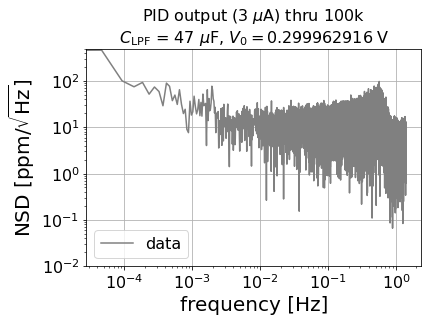

In [168]:
plot_spectrum(
    rn_arr  = [f"C-{i}" for i in range(6)],
    ylim    = (1e-2, 5e2),
    comment = "PID output ($3\;\mu$A) thru 100k\n",
)

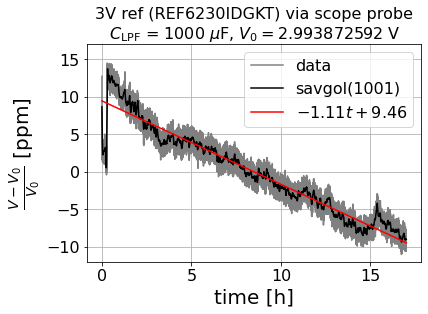

In [188]:
DMM_temp = plot(
    rn_arr  = [f"D-{i}" for i in range(17)],
    ylim    = (-12, 17),
    win_len = 1001,
    comment = "3V ref (REF6230IDGKT) via scope probe\n",
)

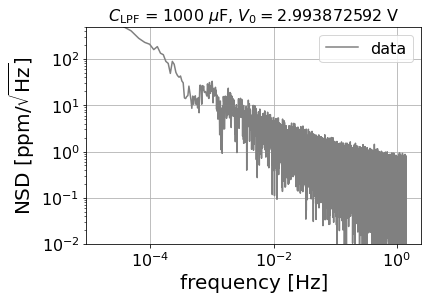

In [114]:
plot_spectrum(
    rn_arr  = [f"D-{i}" for i in range(17)],
    ylim    = (1e-2, 5e2),
    win_len = 1001,
)

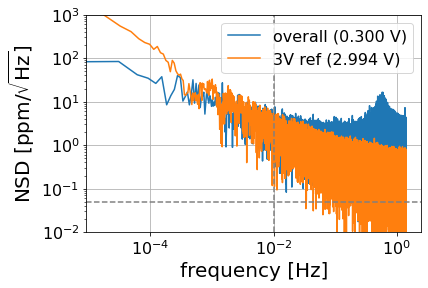

In [197]:
plot_spectra(
    rn_arr_arr = [
                    [f"B-{i}" for i in range(5,14)],
                    [f"D-{i}" for i in range(17)],
                 ],
    lab_arr    = ["overall", "3V ref"],
    V0_arr     = [None, None],
    ylim       = (1e-2, 1e3),
    hline      = 0.05,
    vline      = 1e-2,
)

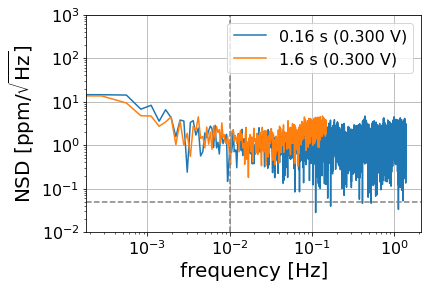

In [227]:
plot_spectra(
    rn_arr_arr = [
                    [f"E-{i}" for i in range(1)],
                    [f"F-{i}" for i in range(1)],
                 ],
    lab_arr    = ["0.16 s", "1.6 s"],
    V0_arr     = [.3, .3],
    ylim       = (1e-2, 1e3),
    hline      = 0.05,
    vline      = 1e-2,
)

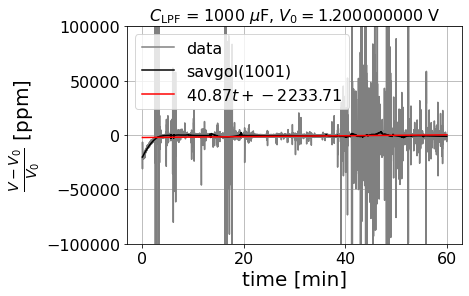

In [226]:
DMM_temp = plot(
    rn_arr  = [f"H-{i}" for i in range(1)],
    ylim    = (-1e5, 1e5),
    win_len = 1001,
    V0      = 1.2,
    Voffs   = .0006,
)

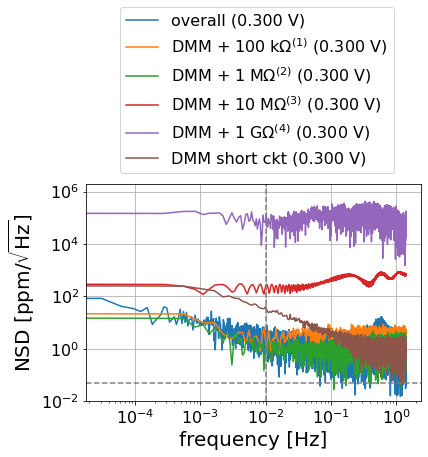

In [355]:
plot_spectra(
    rn_arr_arr = [
                    [f"B-{i}" for i in range(5,14)],
                    [f"I-{i}" for i in range(1)],
                    [f"E-{i}" for i in range(1)],
                    [f"G-{i}" for i in range(1)],
                    [f"H-{i}" for i in range(1)],
                    [f"J-{i}" for i in range(1)],
                 ],
    lab_arr    = ["overall", "DMM + $100\;\mathrm{k}\Omega^{(1)}$",
                  "DMM + $1\;\mathrm{M}\Omega^{(2)}$",
                  "DMM + $10\;\mathrm{M}\Omega^{(3)}$",
                  "DMM + $1\;\mathrm{G}\Omega^{(4)}$",
                  "DMM short ckt"],
    V0_arr     = [None, .3, .3, .3, .3, .3],
    ylim       = (1e-2, 2e6),
    hline      = 0.05,
    vline      = 1e-2,
    legend_pos = (.1, 1.05),
    win_fn     = False,
)

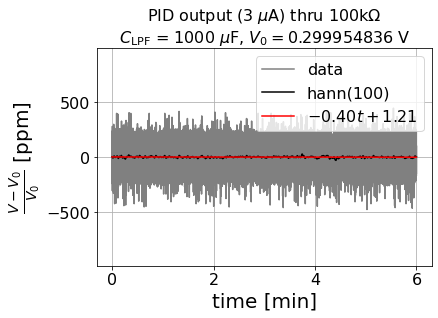

In [374]:
DMM_temp = plot(
    rn_arr  = [f"K-{i}" for i in range(1)],
    ylim    = (-990, 990),
    comment = "PID output ($3\;\mu$A) thru 100k$\Omega$\n",
    win_fn  = windows.hann,
    win_len = 100,
)

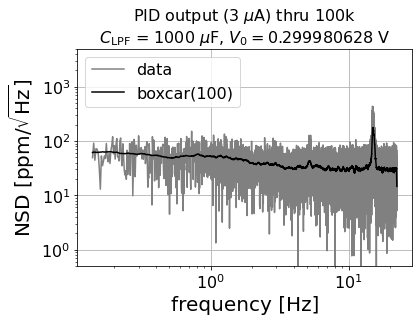

In [376]:
plot_spectrum(
    rn_arr  = [f"K-{i}" for i in range(1)],
    ylim    = (.5, 5e3),
    comment = "PID output ($3\;\mu$A) thru 100k\n",
    win_fn  = windows.boxcar,
    win_len = 100,
)

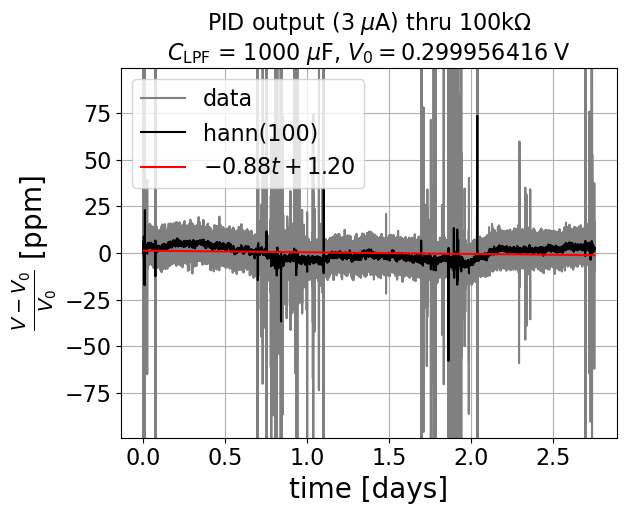

In [97]:
DMM_temp = plot(
    rn_arr  = [f"L-{i}" for i in range(66)],
    ylim    = (-99, 99),
    comment = "PID output ($3\;\mu$A) thru 100k$\Omega$\n",
    win_fn  = windows.hann,
    win_len = 100,
)

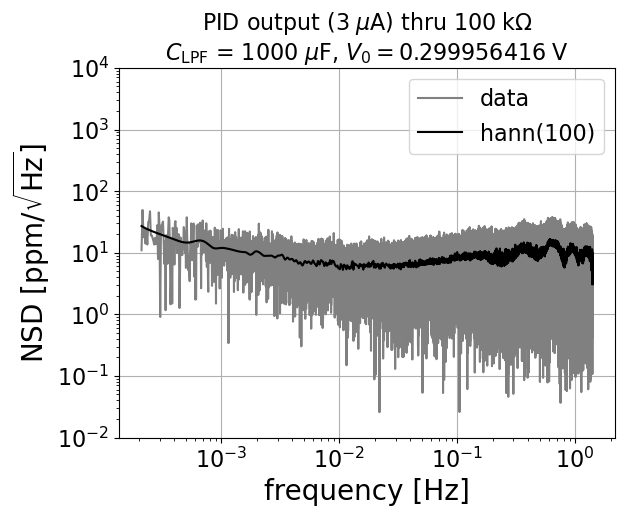

In [102]:
plot_spectrum(
    rn_arr  = [f"L-{i}" for i in range(66)],
    ylim    = (1e-2, 1e4),
    comment = "PID output ($3\;\mu$A) thru 100$\;$k$\Omega$\n",
    win_fn  = windows.hann,
    win_len = 100,
)

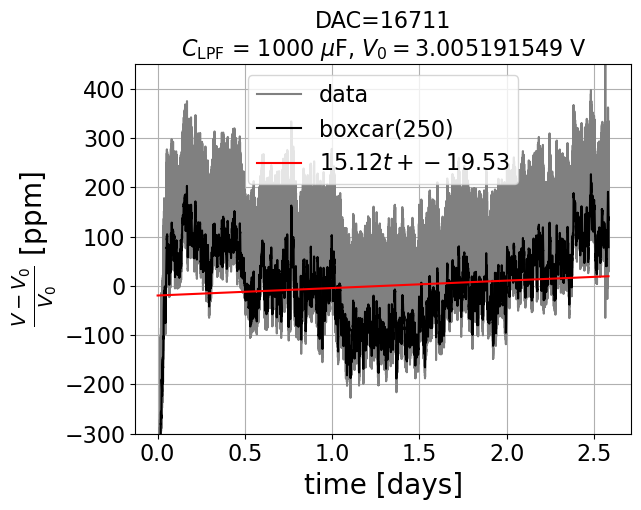

In [91]:
DMM_temp = plot(
    rn_arr  = [f"M-{i}" for i in range(62)],
    ylim    = (-300, 450),
    comment = "DAC=16711\n",
    win_fn  = windows.boxcar,
    win_len = 250,
)

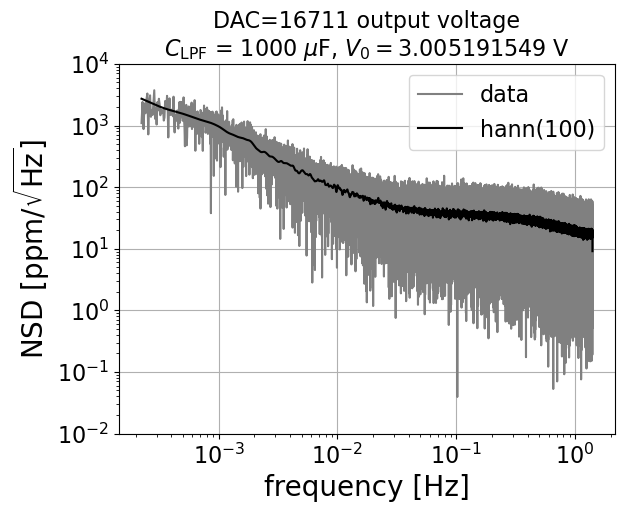

In [103]:
plot_spectrum(
    rn_arr  = [f"M-{i}" for i in range(62)],
    ylim    = (1e-2, 1e4),
    comment = "DAC=16711 output voltage\n",
    win_fn  = windows.hann,
    win_len = 100,
)

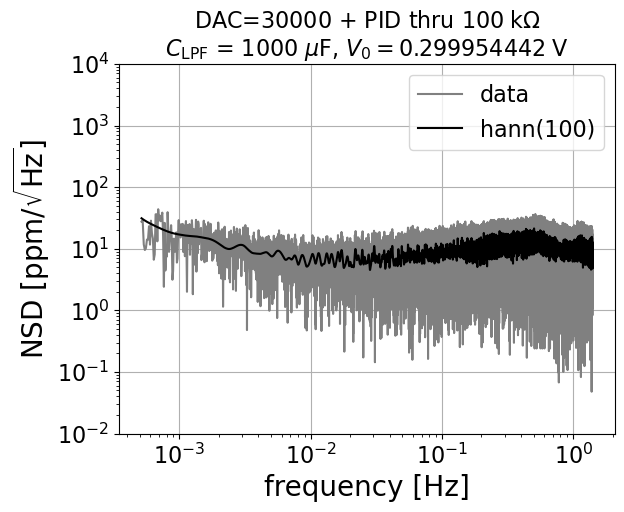

In [112]:
plot_spectrum(
    rn_arr  = [f"N-{i}" for i in range(27)],
    ylim    = (1e-2, 1e4),
    comment = "DAC=30000 + PID thru 100$\;$k$\Omega$\n",
    win_fn  = windows.hann,
    win_len = 100,
)

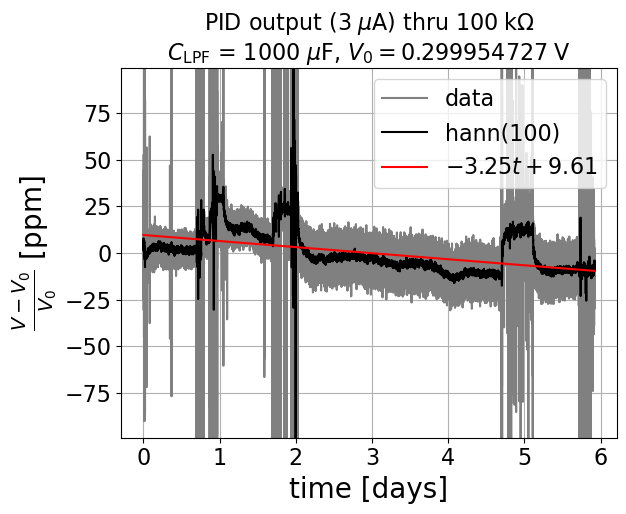

In [24]:
DMM_temp = plot(
    rn_arr  = [f"O-{i}" for i in range(142)],
    ylim    = (-99, 99),
    comment = "PID output ($3\;\mu$A) thru 100$\;$k$\Omega$\n",
    win_fn  = windows.hann,
    win_len = 100,
)

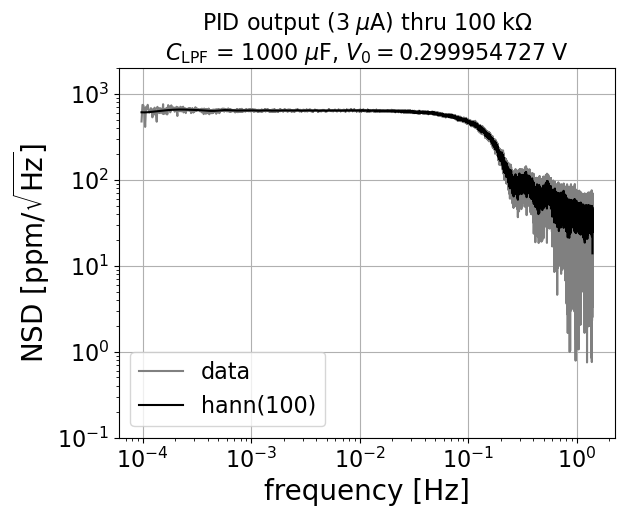

In [23]:
plot_spectrum(
    rn_arr  = [f"O-{i}" for i in range(142)],
    ylim    = (1e-1, 2e3),
    comment = "PID output ($3\;\mu$A) thru 100$\;$k$\Omega$\n",
    win_fn  = windows.hann,
    win_len = 100,
)